AUC Results:
CNN - TCGA: 0.6804
CNN - DACHS: 0.7351
STAMP - 0: 0.5478
STAMP - 1: 0.4301
STAMP - 2: 0.6765
Histobistro: 0.6654

NPV Results:
CNN - TCGA: 0.8312
CNN - DACHS: 1.0000
STAMP - 0: 0.8281
STAMP - 1: 0.7727
STAMP - 2: 0.9655
Histobistro: 0.8647


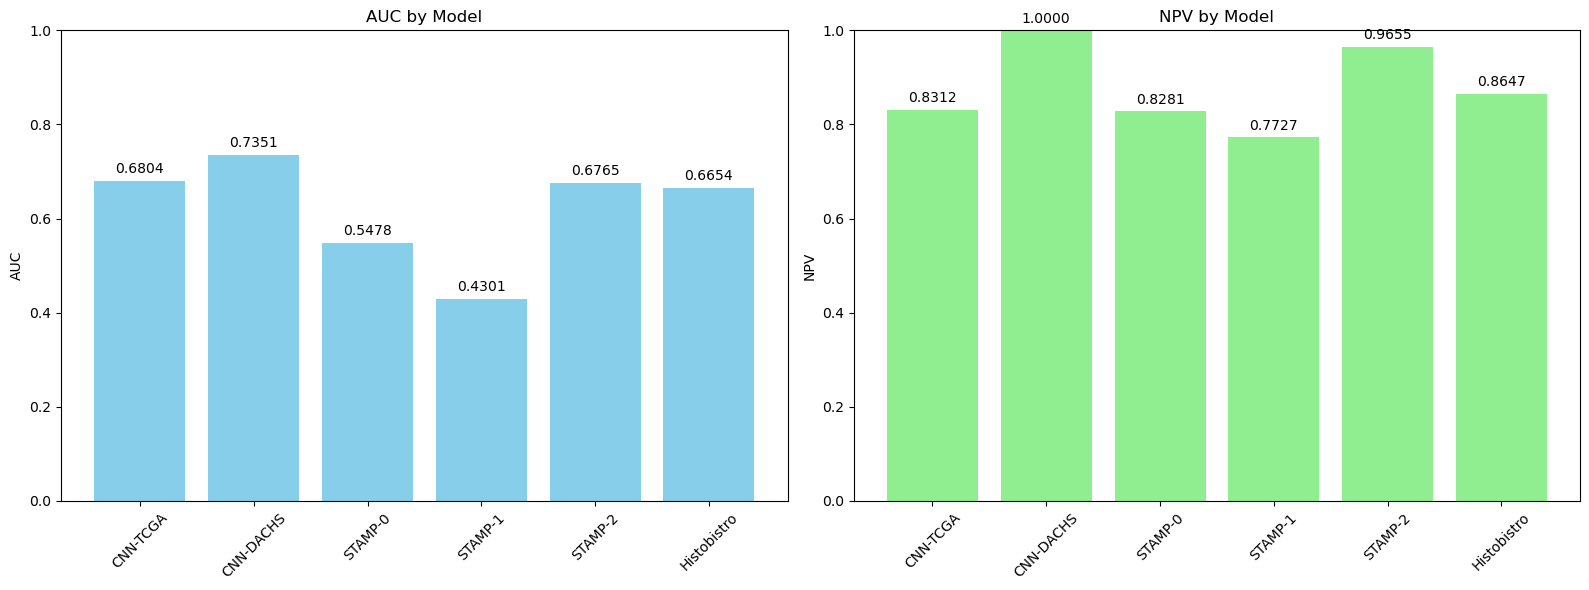

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix

def calculate_metrics():
    # Load the datasets
    tcga_df = pd.read_csv('CNN/TEST_RESULT_PATIENT_BASED_FULL_tcga.csv')
    dachs_df = pd.read_csv('CNN/TEST_RESULT_PATIENT_BASED_FULL_dachs.csv')
    stamp_df1 = pd.read_csv('STAMP/patient-preds_0.csv')
    stamp_df2 = pd.read_csv('STAMP/patient-preds_1.csv')
    stamp_df3 = pd.read_csv('STAMP/patient-preds_2.csv')
    histobistro_df = pd.read_csv('histobistro/histobistro_outputs_all.csv')
    
    # Calculate AUC for each model
    # For CNN models, we need to invert the true labels (or use nonMSIH scores) 
    # since 0=MSIH, 1=nonMSIH, but higher MSIH scores indicate MSIH class
    
    # CNN - TCGA - Option 1: Invert the labels
    y_true_tcga_inverted = 1 - tcga_df['yTrue']
    y_score_tcga = tcga_df['MSIH']
    auc_tcga = roc_auc_score(y_true_tcga_inverted, y_score_tcga)
    
    # CNN - DACHS - Option 1: Invert the labels
    y_true_dachs_inverted = 1 - dachs_df['yTrue']
    y_score_dachs = dachs_df['MSIH']
    auc_dachs = roc_auc_score(y_true_dachs_inverted, y_score_dachs)
    
    # STAMP datasets - Convert MSI-H/MSS to binary
    stamp_df1['isMSIH_binary'] = (stamp_df1['isMSIH'] == 'MSI-H').astype(int)
    stamp_df2['isMSIH_binary'] = (stamp_df2['isMSIH'] == 'MSI-H').astype(int)
    stamp_df3['isMSIH_binary'] = (stamp_df3['isMSIH'] == 'MSI-H').astype(int)
    
    # STAMP - 0
    y_true_stamp1 = stamp_df1['isMSIH_binary']
    y_score_stamp1 = stamp_df1['isMSIH_MSI-H']
    auc_stamp1 = roc_auc_score(y_true_stamp1, y_score_stamp1)
    
    # STAMP - 1
    y_true_stamp2 = stamp_df2['isMSIH_binary']
    y_score_stamp2 = stamp_df2['isMSIH_MSI-H']
    auc_stamp2 = roc_auc_score(y_true_stamp2, y_score_stamp2)
    
    # STAMP - 2
    y_true_stamp3 = stamp_df3['isMSIH_binary']
    y_score_stamp3 = stamp_df3['isMSIH_MSI-H']
    auc_stamp3 = roc_auc_score(y_true_stamp3, y_score_stamp3)
    
    # Histobistro - skip the first unnamed column
    histobistro_df = histobistro_df.iloc[:, 1:]
    # Convert predictions to float if they're strings
    histobistro_df['prediction'] = histobistro_df['prediction'].astype(float)
    y_true_histobistro = histobistro_df['ground_truth'].astype(int)
    y_score_histobistro = histobistro_df['prediction']
    auc_histobistro = roc_auc_score(y_true_histobistro, y_score_histobistro)
    
    # Calculate NPV (Negative Predictive Value) for each model
    # NPV = TN / (TN + FN)
    
    # Following the R code example, use threshold 0.3 instead of 0.5
    threshold = 0.5
    
    # CNN - TCGA
    # For NPV with inverted true values:
    # Class 0 (nonMSIH in inverted) is negative, class 1 (MSIH in inverted) is positive
    y_pred_tcga = (tcga_df['MSIH'] >= threshold).astype(int)
    tn_tcga, fp_tcga, fn_tcga, tp_tcga = confusion_matrix(y_true_tcga_inverted, y_pred_tcga).ravel()
    npv_tcga = tn_tcga / (tn_tcga + fn_tcga) if (tn_tcga + fn_tcga) > 0 else 0
    
    # CNN - DACHS
    y_pred_dachs = (dachs_df['MSIH'] >= threshold).astype(int)
    tn_dachs, fp_dachs, fn_dachs, tp_dachs = confusion_matrix(y_true_dachs_inverted, y_pred_dachs).ravel()
    npv_dachs = tn_dachs / (tn_dachs + fn_dachs) if (tn_dachs + fn_dachs) > 0 else 0
    
    # STAMP - 0
    y_pred_stamp1 = (stamp_df1['isMSIH_MSI-H'] >= threshold).astype(int)
    tn_stamp1, fp_stamp1, fn_stamp1, tp_stamp1 = confusion_matrix(y_true_stamp1, y_pred_stamp1).ravel()
    npv_stamp1 = tn_stamp1 / (tn_stamp1 + fn_stamp1) if (tn_stamp1 + fn_stamp1) > 0 else 0
    
    # STAMP - 1
    y_pred_stamp2 = (stamp_df2['isMSIH_MSI-H'] >= threshold).astype(int)
    tn_stamp2, fp_stamp2, fn_stamp2, tp_stamp2 = confusion_matrix(y_true_stamp2, y_pred_stamp2).ravel()
    npv_stamp2 = tn_stamp2 / (tn_stamp2 + fn_stamp2) if (tn_stamp2 + fn_stamp2) > 0 else 0
    
    # STAMP - 2
    y_pred_stamp3 = (stamp_df3['isMSIH_MSI-H'] >= threshold).astype(int)
    tn_stamp3, fp_stamp3, fn_stamp3, tp_stamp3 = confusion_matrix(y_true_stamp3, y_pred_stamp3).ravel()
    npv_stamp3 = tn_stamp3 / (tn_stamp3 + fn_stamp3) if (tn_stamp3 + fn_stamp3) > 0 else 0
    
    # Histobistro
    # For binary predictions, threshold at 0.5
    y_pred_histobistro = (histobistro_df['prediction'] >= 0.5).astype(int)
    tn_histobistro, fp_histobistro, fn_histobistro, tp_histobistro = confusion_matrix(y_true_histobistro, y_pred_histobistro).ravel()
    npv_histobistro = tn_histobistro / (tn_histobistro + fn_histobistro) if (tn_histobistro + fn_histobistro) > 0 else 0
    
    # Print results
    print("AUC Results:")
    print(f"CNN - TCGA: {auc_tcga:.4f}")
    print(f"CNN - DACHS: {auc_dachs:.4f}")
    print(f"STAMP - 0: {auc_stamp1:.4f}")
    print(f"STAMP - 1: {auc_stamp2:.4f}")
    print(f"STAMP - 2: {auc_stamp3:.4f}")
    print(f"Histobistro: {auc_histobistro:.4f}")
    
    print("\nNPV Results:")
    print(f"CNN - TCGA: {npv_tcga:.4f}")
    print(f"CNN - DACHS: {npv_dachs:.4f}")
    print(f"STAMP - 0: {npv_stamp1:.4f}")
    print(f"STAMP - 1: {npv_stamp2:.4f}")
    print(f"STAMP - 2: {npv_stamp3:.4f}")
    print(f"Histobistro: {npv_histobistro:.4f}")
    
    # Return the metrics for further analysis if needed
    return {
        'auc': {
            'cnn_tcga': auc_tcga,
            'cnn_dachs': auc_dachs,
            'stamp_0': auc_stamp1,
            'stamp_1': auc_stamp2,
            'stamp_2': auc_stamp3,
            'histobistro': auc_histobistro
        },
        'npv': {
            'cnn_tcga': npv_tcga,
            'cnn_dachs': npv_dachs,
            'stamp_0': npv_stamp1,
            'stamp_1': npv_stamp2,
            'stamp_2': npv_stamp3,
            'histobistro': npv_histobistro
        }
    }

# Call the function to calculate metrics
metrics = calculate_metrics()

# Add visualization function
import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    models = ['CNN-TCGA', 'CNN-DACHS', 'STAMP-0', 'STAMP-1', 'STAMP-2', 'Histobistro']
    auc_values = [
        metrics['auc']['cnn_tcga'],
        metrics['auc']['cnn_dachs'],
        metrics['auc']['stamp_0'],
        metrics['auc']['stamp_1'],
        metrics['auc']['stamp_2'],
        metrics['auc']['histobistro']
    ]
    npv_values = [
        metrics['npv']['cnn_tcga'],
        metrics['npv']['cnn_dachs'],
        metrics['npv']['stamp_0'],
        metrics['npv']['stamp_1'],
        metrics['npv']['stamp_2'],
        metrics['npv']['histobistro']
    ]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot AUC values
    bars1 = ax1.bar(models, auc_values, color='skyblue')
    ax1.set_title('AUC by Model')
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('AUC')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Plot NPV values
    bars2 = ax2.bar(models, npv_values, color='lightgreen')
    ax2.set_title('NPV by Model')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('NPV')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png')
    plt.show()
git ad
# Visualize the metrics
visualize_metrics(metrics)